# Evaluate *ritme* trials of all usecases


## Setup

In [1]:
import warnings
import pandas as pd

from src.evaluate_trials import (
    plot_complexity_vs_metric,
    plot_trend_over_time,
    boxplot_metric,
    multi_boxplot_metric,
)

warnings.filterwarnings("ignore", category=FutureWarning)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
######## USER INPUTS ########

# path to extracted MLflow logs - with script extract_all_logs.sh
log_folder_location = "merged_u1_u2_runs_work_no2trac.csv"

# which usecase to analyze: "u1", "u2", "u3" or "all"
usecase = "u2"
# which samplers to analyse: "tpe", "random" or "all"
sampler = "tpe"
# whether to only analyze one model type or all (="all")
model_type = "all"

# how many trials to consider for complexity vs. performance plot
top_x = 1000

# figure saving dpi
dpi = 400
######## END USER INPUTS #####

In [3]:
# set title
if usecase == "u1":
    title = "Usecase 1"
elif usecase == "u2":
    title = "Usecase 2"
elif usecase == "u3":
    title = "Usecase 3"
else:
    title = "All usecases"

## Extract trial information

In [4]:
# extract all trial information
all_trials = pd.read_csv(log_folder_location)
# sort by asc metrics.rmse_val
all_trials = all_trials.sort_values(by="metrics.rmse_val", ascending=True)
print(f"Found {all_trials.shape[0]} trials")

/var/folders/k3/lydcv_vx7cb6tzmkf7k8xvsw0000gp/T/ipykernel_33083/826638946.py:2: DtypeWarning: Columns (56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  all_trials = pd.read_csv(log_folder_location)


Found 52500 trials


In [5]:
if usecase != "all":
    print(f"Analyzing trials for usecase: {usecase}")
    all_trials = all_trials[all_trials["tags.experiment_tag"].str.startswith(usecase)]

if sampler != "all":
    print(f"Analyzing trials for sampler: {sampler}")
    all_trials = all_trials[all_trials["tags.experiment_tag"].str.contains(sampler)]

if model_type != "all":
    print(f"Analyzing trials for model type: {model_type}")
    all_trials = all_trials[all_trials["params.model"] == model_type]

print(f"Selected {all_trials.shape[0]} trials")

Analyzing trials for usecase: u2
Analyzing trials for sampler: tpe
Selected 15000 trials


## Insights on performance

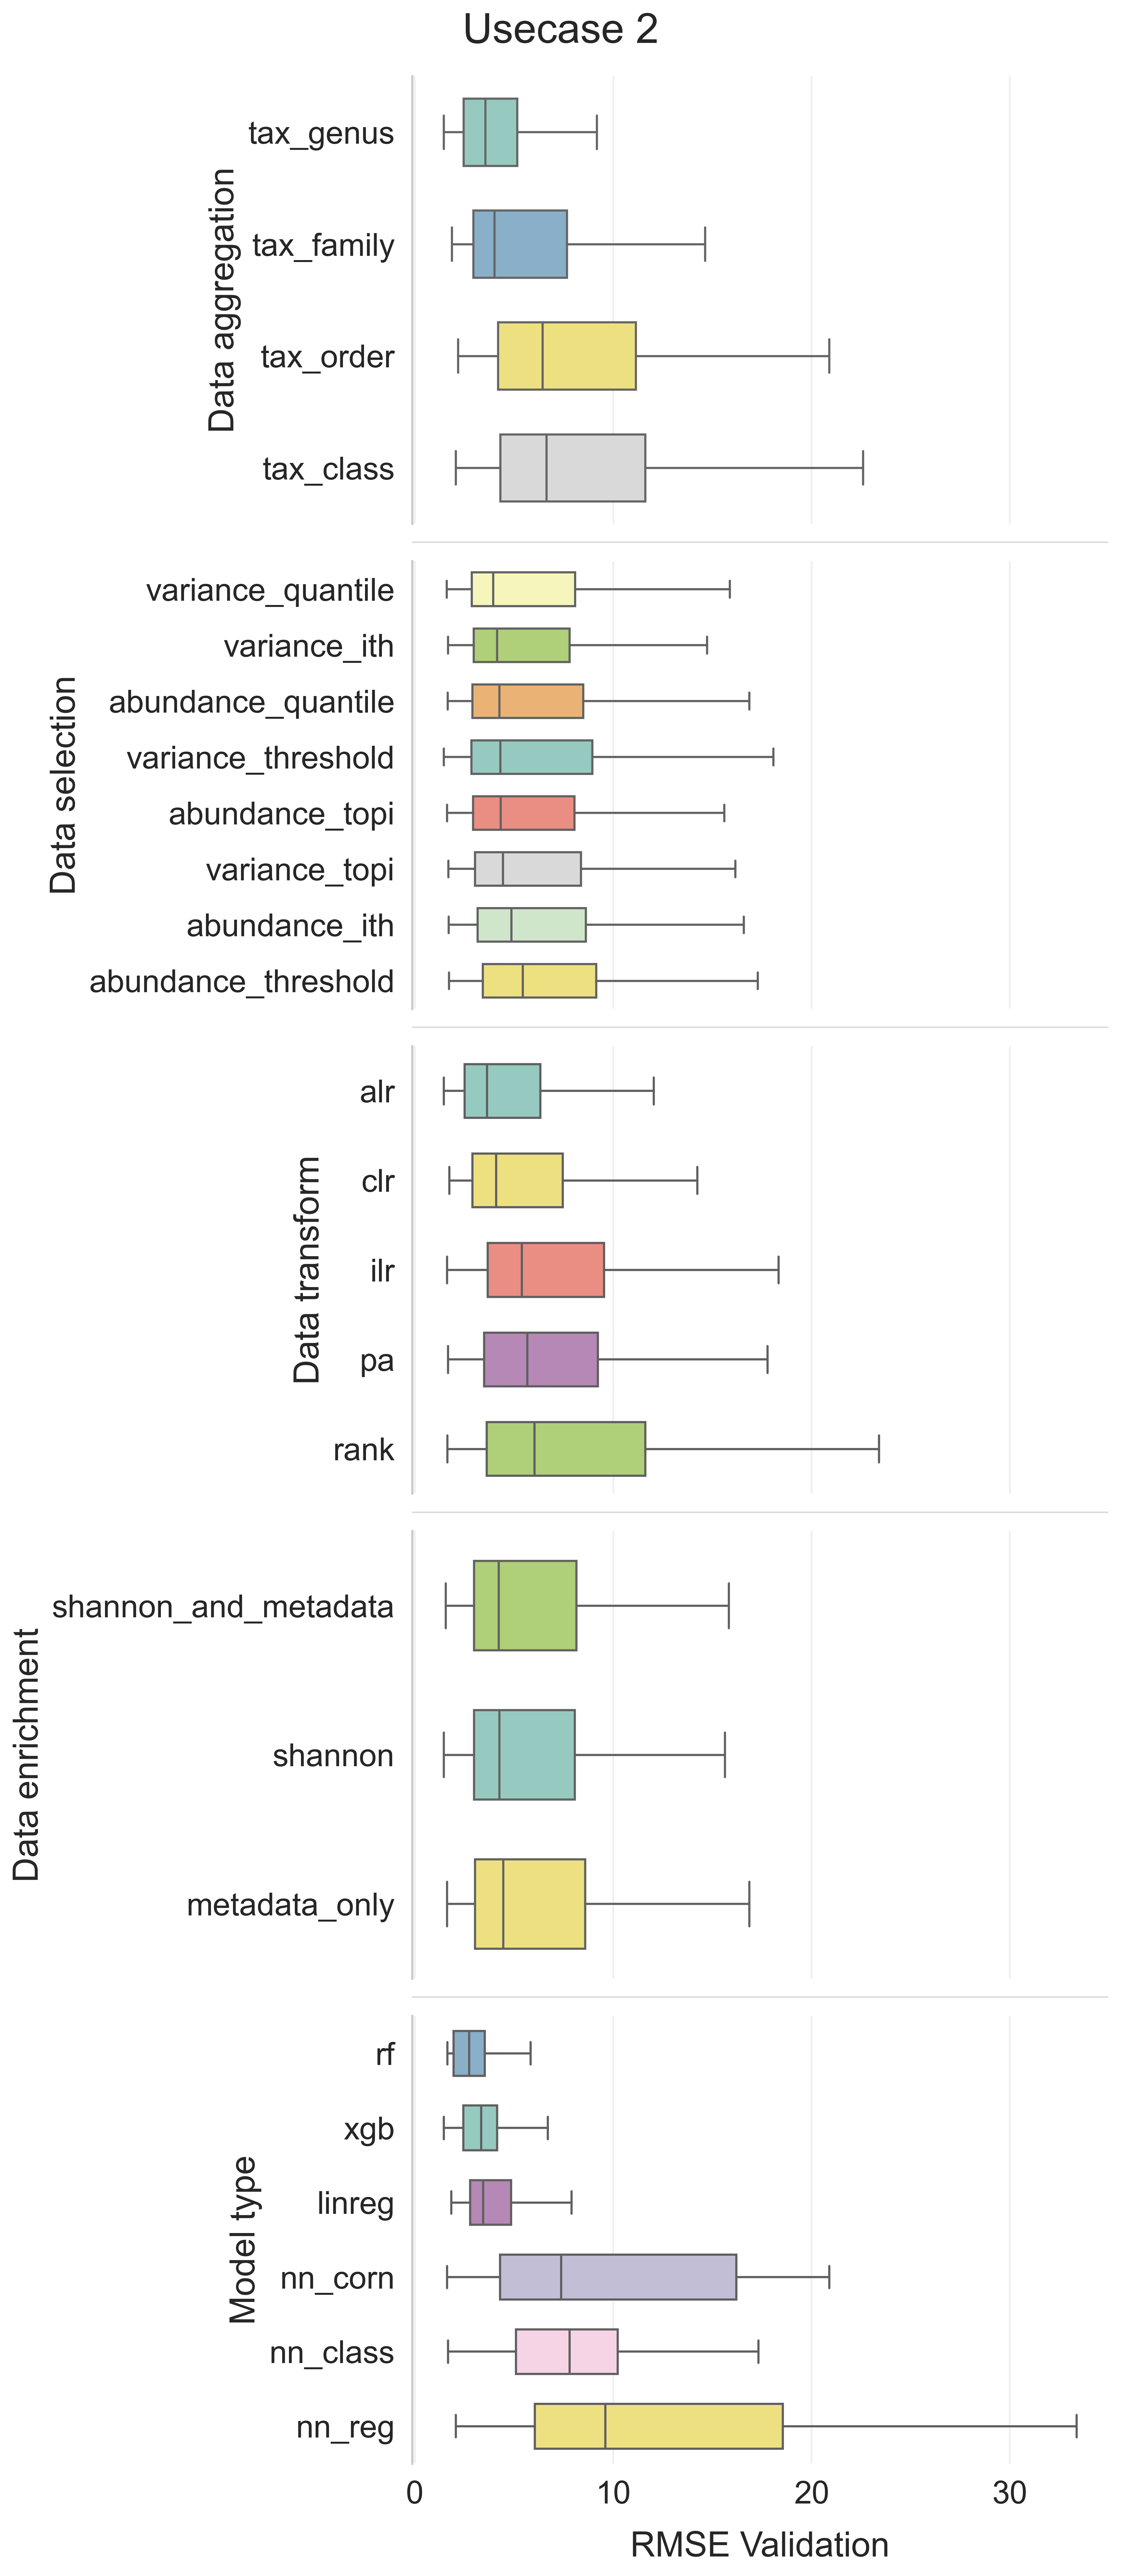

In [6]:
fig, axes = multi_boxplot_metric(
    all_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_specs=[
        ("params.data_aggregation", "Data aggregation"),
        ("params.data_selection", "Data selection"),
        ("params.data_transform", "Data transform"),
        ("params.data_enrich", "Data enrichment"),
        ("params.model", "Model type"),
    ],
    order_by_median=True,
    showfliers=False,
    title=title,
)
fig.savefig(
    f"result_figures/boxplot_all_trials_{usecase}.pdf", bbox_inches="tight", dpi=dpi
)

## Model complexity vs. performance: top X trials

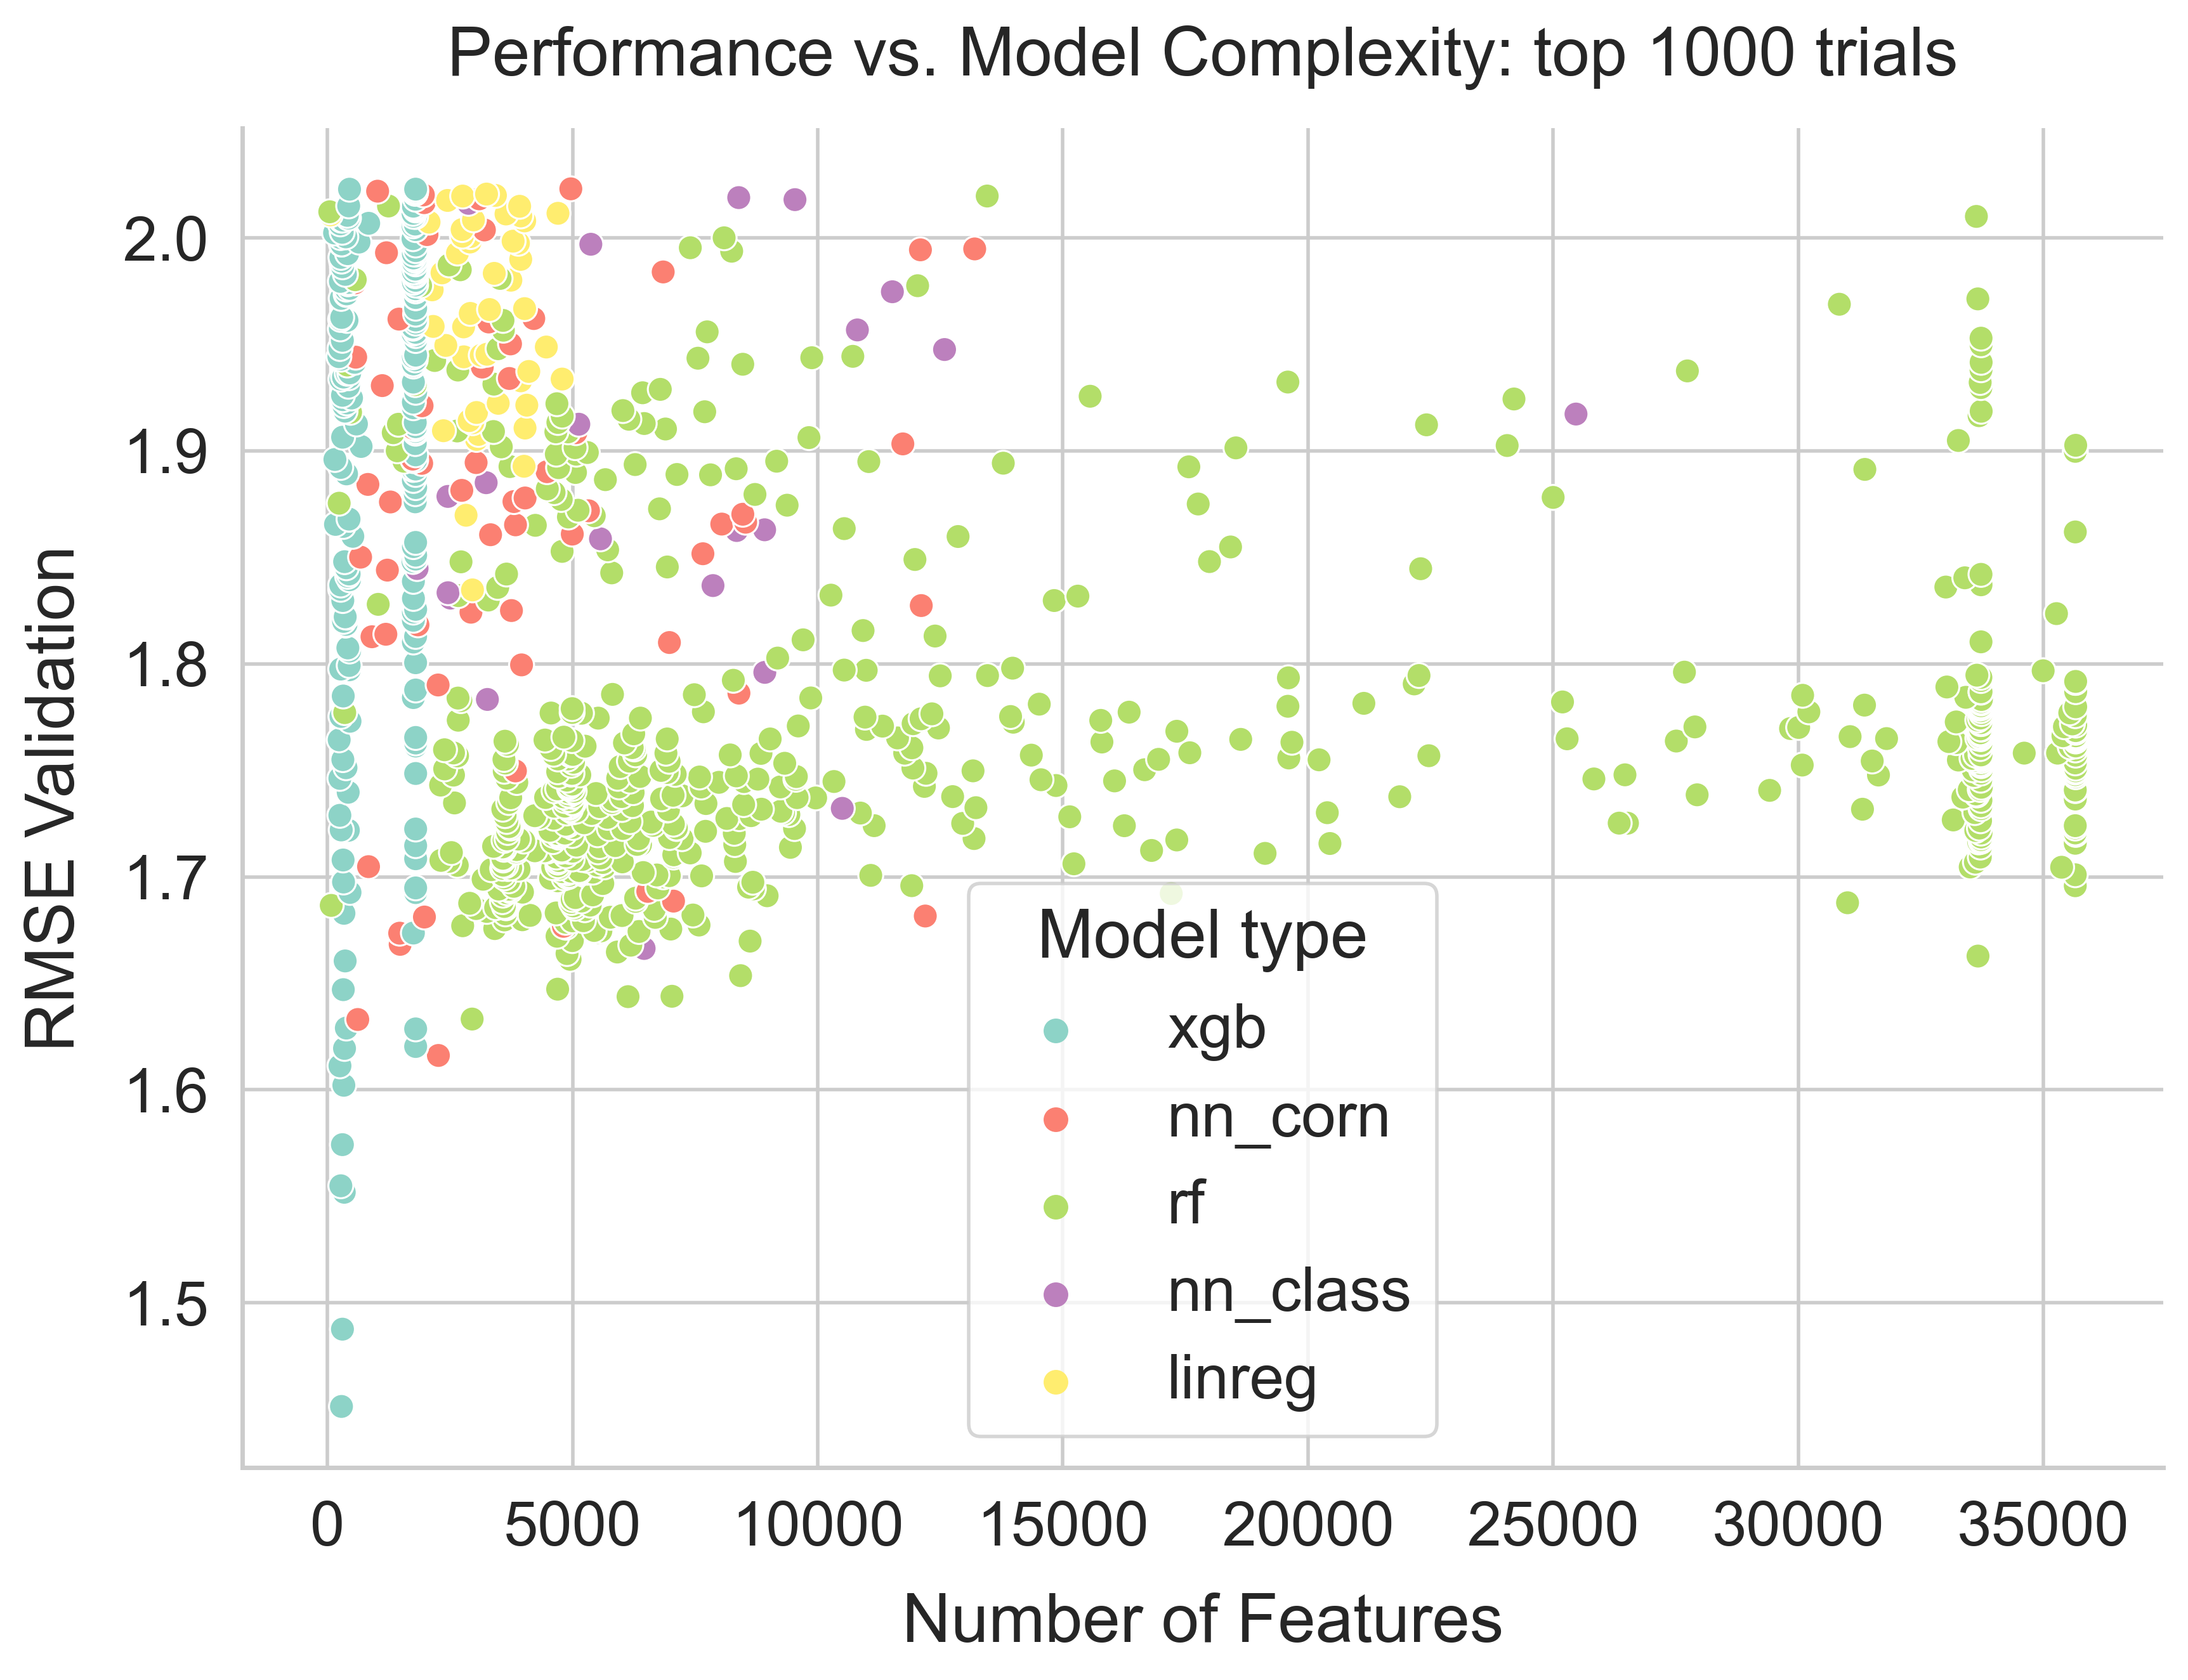

In [8]:
top_x_trials = all_trials.head(top_x)
top_x_trials["params.model"].value_counts()
figc, _ = plot_complexity_vs_metric(
    top_x_trials,
    metric_col="metrics.rmse_val",
    metric_name="RMSE Validation",
    group_col="params.model",
    group_name="Model type",
    n=top_x,
    figsize=(9, 7),
)

figc.savefig(
    f"result_figures/complexity_all_trials_{usecase}.pdf", bbox_inches="tight", dpi=dpi
)

In [9]:
## Training over time

# metric = "rmse_val"
# for model in all_trials["params.model"].unique():
#     print(f"Plotting trend for model: {model}")
#     model_trials = all_trials[all_trials["params.model"] == model]
#     plot_trend_over_time(
#         model_trials, f"metrics.{metric}", window=100, title_prefix=f"Model: {model}", figsize=(12, 6
#     ))